# Timeseries Forecasting

Some preliminary examples of timeseries forecasting.

This is based on: https://huggingface.co/blog/time-series-transformers

Install some libs and do imports:

In [ ]:
# !pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate
!pip install -q gluonts ujson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Datasets

Load a relevant datasets and display it

In [2]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset monash_tsf (/Users/felixnext/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050)
100%|██████████| 3/3 [00:00<00:00, 82.18it/s]


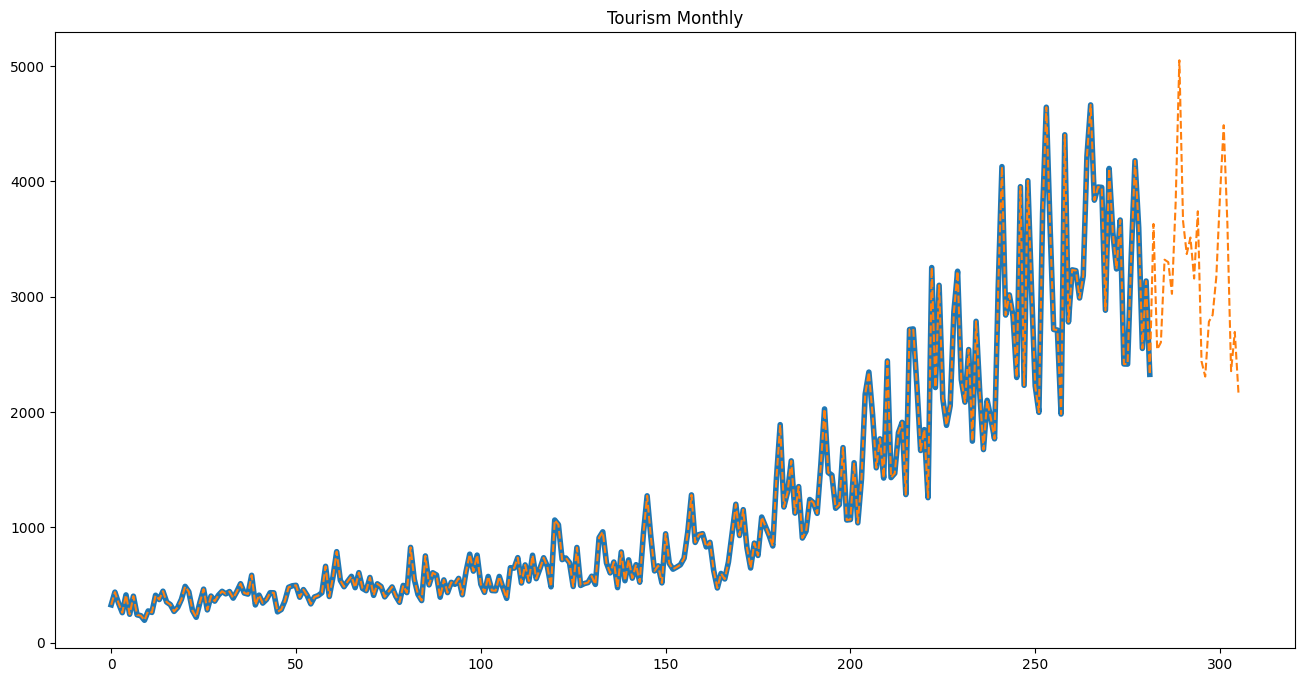

In [4]:
# visualize the dataset
ds_train = dataset["train"]
ds_val = dataset["validation"]
ds_train[0]["target"]

# plot data as equal time steps
def plot_data(i: int, title: str):
    plt.figure(figsize=(16, 8))
    plt.title(title)

    ytar = ds_train[i]["target"]
    xtar = np.arange(len(ytar))
    yval = ds_val[i]["target"]
    xval = np.arange(len(yval))

    # plot two lines (make train blue and test dashed)
    plt.plot(xtar, ytar, label="train", linewidth=4)
    plt.plot(xval, yval, label="test", linestyle="--")

    plt.show()

plot_data(100, "Tourism Monthly")

# assert length
pred_len = 24
for i in range(len(ds_train)):
    assert len(ds_train[i]["target"]) + pred_len == len(ds_val[i]["target"])

We asserted that validation prediction is always 24 items longer then training prediction (meaning we should predict 24 steps in the future). (Meaning we have unseen data in our validation set)

In [5]:
train_ds = dataset["train"]
test_ds = dataset["test"]

from functools import lru_cache, partial
from datetime import datetime
import logging

# NOTE: lru_cache is used for memoization to speed up the conversion
@lru_cache(maxsize=10_000)
def convert_to_pandas_period(date: datetime, freq: str = "1M") -> pd.Period:
    return pd.Period(date, freq)

def transform_start_field(batch: dict, freq: str = "1M") -> dict:
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

# NOTE: essentially partial does currying
train_ds.set_transform(partial(transform_start_field))
test_ds.set_transform(partial(transform_start_field))

## Model Definition

The model has a certain set of hyperparameters that can be tuned. We will use the following:

- `prediction_length`: the number of time steps we want to predict
- `context_length`: the number of time steps that condition the predictions
- `static_features`: the list of static features we want to use (that are unchanging over time)
- `time_features`: the list of time features we want to use (that change over time, i.e. they are computed for each time step)
- `lags`: the list of time lags we want to use as input features (on the context length input series for a specific time step)
- `embedding_size`: Dimensions for the inner embeddings that are learned
- `cardinality`: The number of different values for each categorical feature

Start with the time lags and additional features. Note here that libraries such as `gluonts` have a lot of built-in features that can be used (and are provided directly based on the frequency). We will use the following:

In [6]:
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str

freq = "1M"

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

time_features = time_features_from_frequency_str(freq)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]
[<function month_of_year at 0x18af9c9a0>]


Next step is to actually create a model

In [9]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=pred_len,
    context_length=pred_len*3, # context length
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1, # we'll add 2 time features ("month of year" and "age", see further)
    num_static_categorical_features=1, # we have a single static categorical feature, namely time series ID
    cardinality=[len(train_ds)], # it has 366 possible values
    embedding_dimension=[2], # the model will learn an embedding of size 2 for each of the 366 possible values
    encoder_layers=4, 
    decoder_layers=4,
)

model = TimeSeriesTransformerForPrediction(config)
model.config.distribution_output

'student_t'

Note that this predicts a continuous distribution and not a categorical distribtion defined by a vector output.